In [ ]:
import os, cv2
os.environ["CUDA_VISIBLE_DEVICES"] = '3,2,1,0'
from glob import glob
import numpy as np
from utils import *
import matplotlib.pyplot as plt

from PIL import Image

In [ ]:
new_images=sorted(glob("../../../KMIT_Datasets/new_data/*/images/*.jpg"))
new_masks=sorted(glob("../../../KMIT_Datasets/new_data/*/masks/*.jpg"))

In [ ]:
loc="../../../../datasets/temp-dataset-location/tubule/Data"
masks=glob(loc+"/*/*mask*")
images=[]
for j in masks:
    temp=j.split("/")[-1].split("-")[0]
    ls=glob(loc+"/*/*"+temp+"*")
    for i in ls:
        if not ("mask" in i):
            images.append(i)

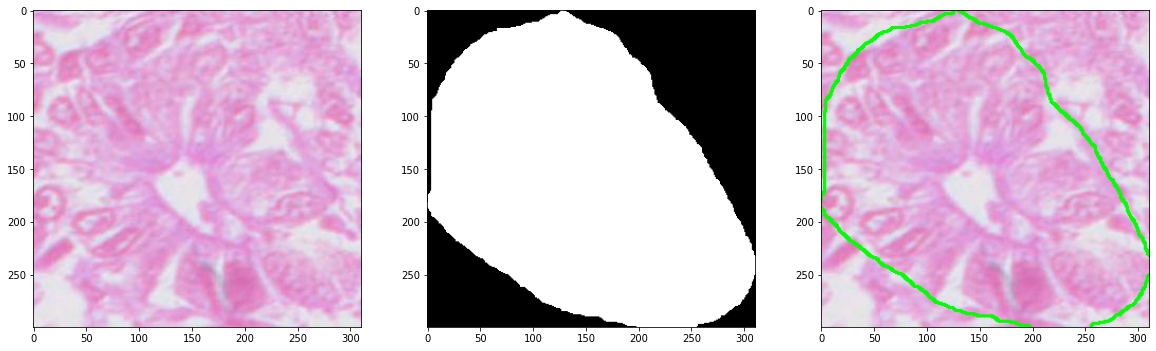

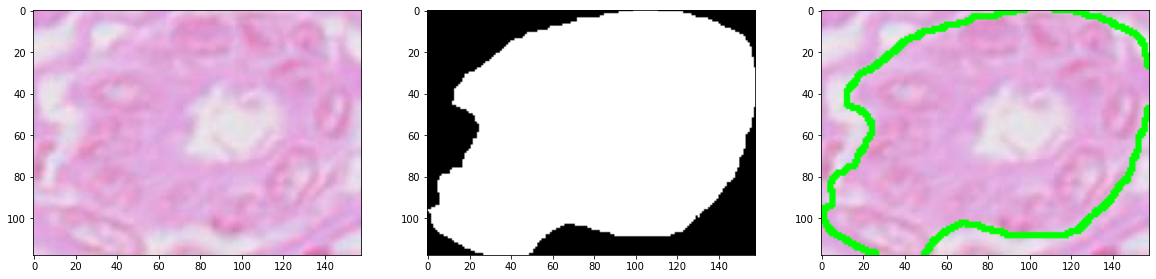

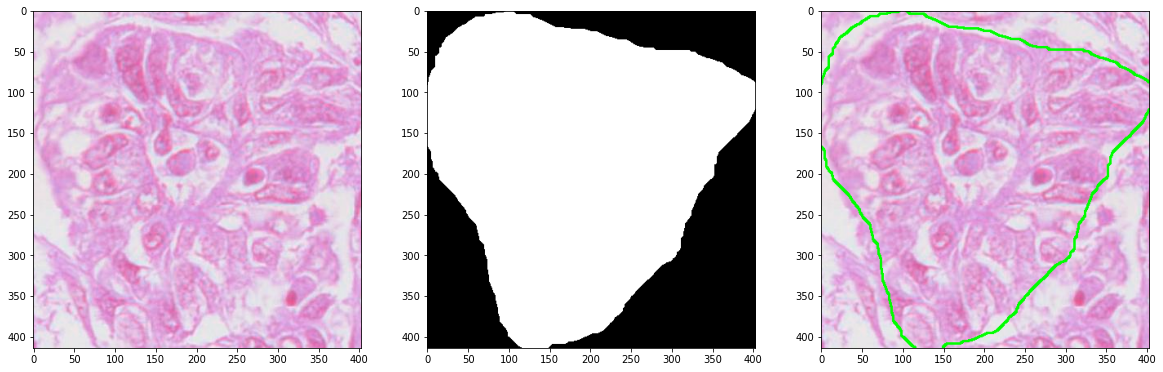

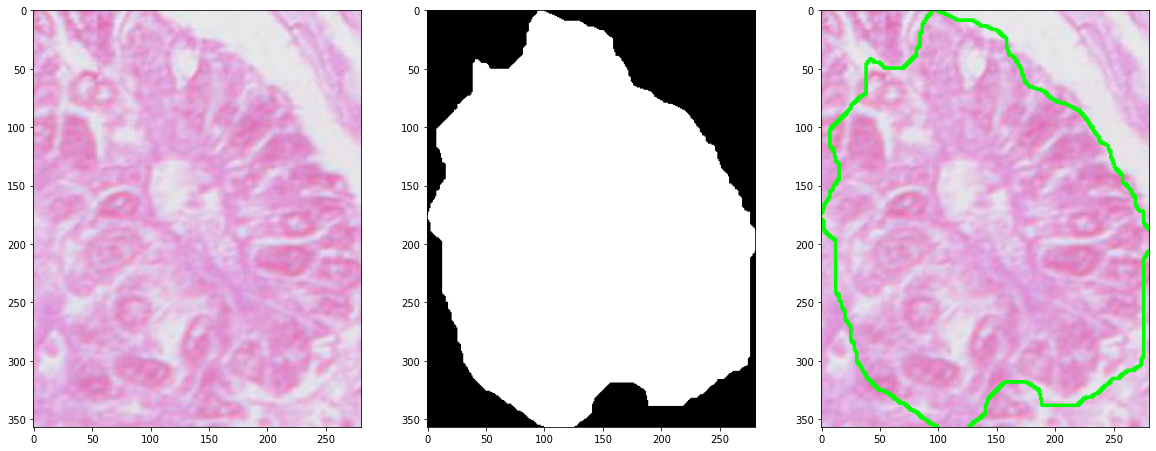

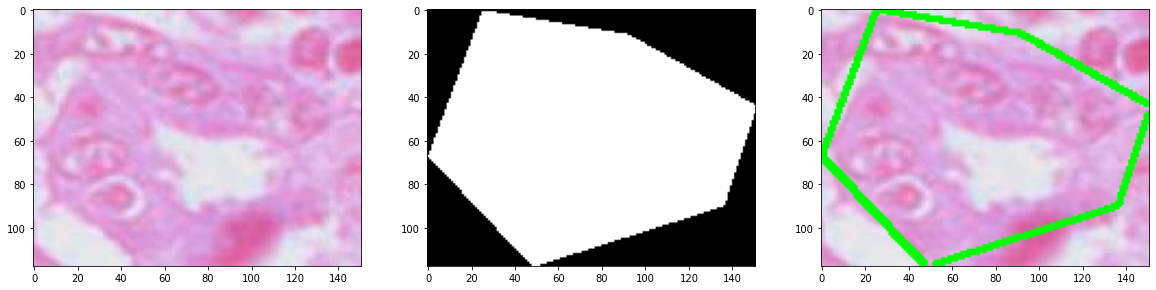

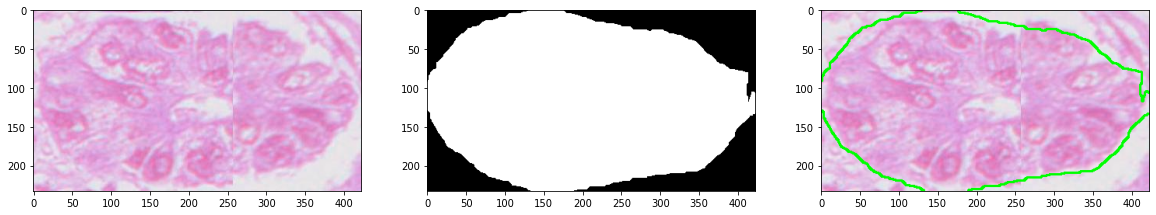

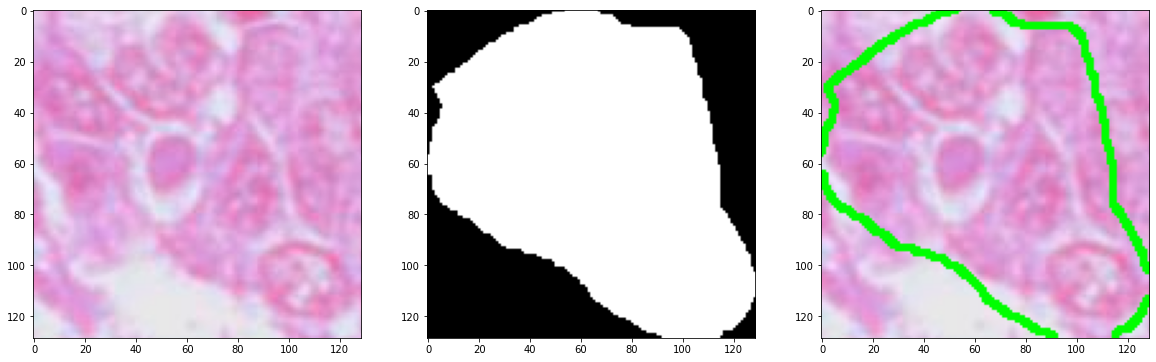

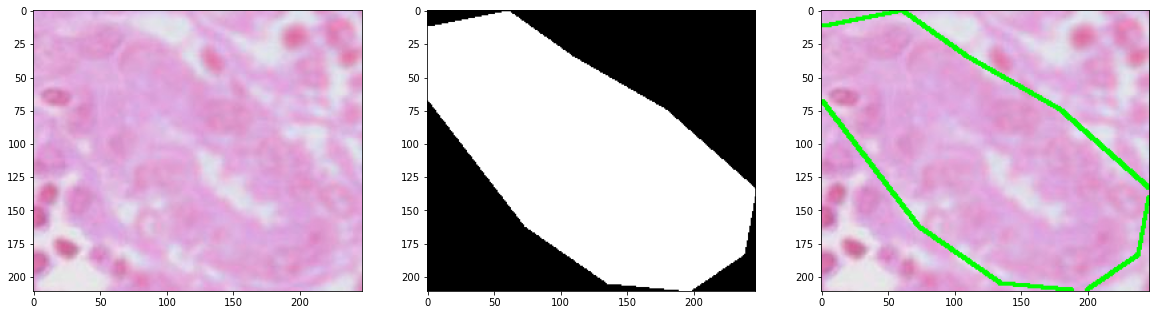

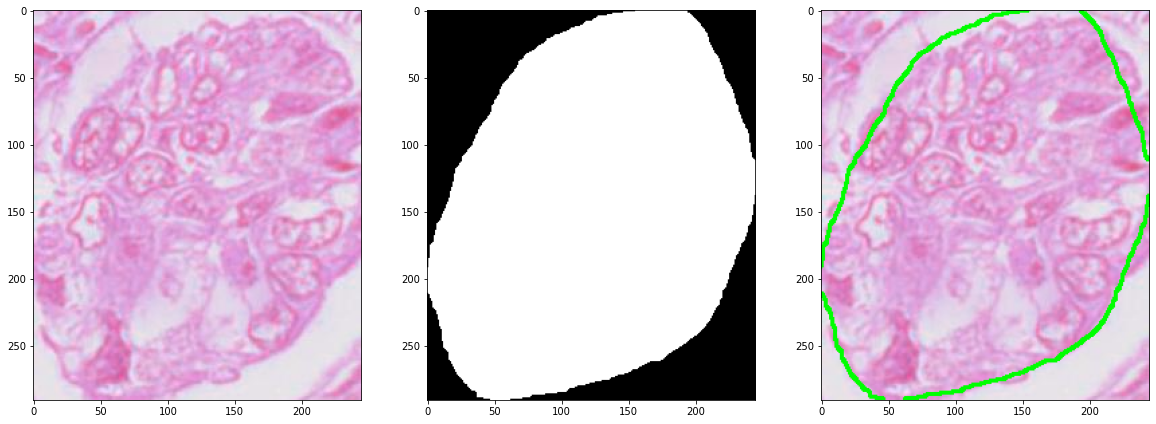

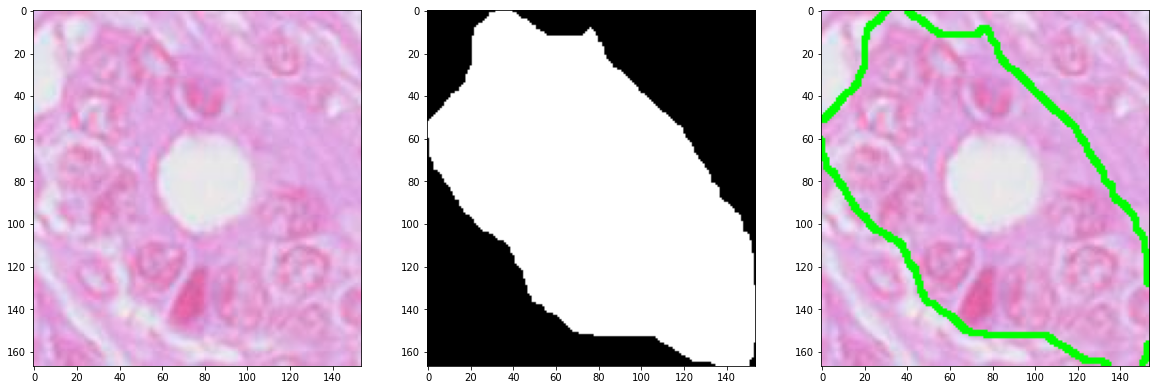

In [4]:
if True:
    for i in range(10):
        fig = plt.figure(figsize=(20,20))
        image = cv2.imread(images[i])
        mask = cv2.threshold(cv2.imread(masks[i], 0),127,255,cv2.THRESH_BINARY)[1]
        a = fig.add_subplot(1,3,1)
        a.imshow(image)
        a = fig.add_subplot(1,3,2)
        a.imshow(mask,  cmap = 'gray')
        a = fig.add_subplot(1,3,3)
        a.imshow(contour_img(image, mask))

In [4]:
newsize=(256,256)

x = []; y = []

    
for image, mask in zip(new_images, new_masks):
    img = Image.open(image)
    img=img.resize(newsize)
    pil_image = img.convert('RGB') 
    open_cv_image = np.array(pil_image) 
    img = open_cv_image[:, :, ::-1].copy() 
    x.append(img)
    x.append(cv2.flip(img, 0))
    x.append(cv2.flip(img, -1))
    x.append(cv2.flip(img, 1))
    msk = Image.open(mask)
    msk=msk.resize(newsize)
    pil_image = msk.convert('RGB') 
    open_cv_image = np.array(pil_image) 
    msk = open_cv_image[:, :, ::-1].copy()
    msk=cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    #msk = (cv2.threshold(cv2.imread(mask, 0),127,255,cv2.THRESH_BINARY)[1]//255.0).reshape(256,256,1)
    msk = (cv2.threshold(msk,127,255,cv2.THRESH_BINARY)[1]//255.0).reshape(256,256,1)
    y.append(msk)
    y.append(cv2.flip(msk, 0).reshape(256,256,1))
    y.append(cv2.flip(msk, -1).reshape(256,256,1))
    y.append(cv2.flip(msk, 1).reshape(256,256,1))
for image, mask in zip(images, masks):
    img = Image.open(image)
    img=img.resize(newsize)
    pil_image = img.convert('RGB') 
    open_cv_image = np.array(pil_image) 
    img = open_cv_image[:, :, ::-1].copy() 
    x.append(img)
    x.append(cv2.flip(img, 0))
    x.append(cv2.flip(img, -1))
    x.append(cv2.flip(img, 1))
    msk = Image.open(mask)
    msk=msk.resize(newsize)
    pil_image = msk.convert('RGB') 
    open_cv_image = np.array(pil_image) 
    msk = open_cv_image[:, :, ::-1].copy()
    msk=cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    #msk = (cv2.threshold(cv2.imread(mask, 0),127,255,cv2.THRESH_BINARY)[1]//255.0).reshape(256,256,1)
    msk = (cv2.threshold(msk,127,255,cv2.THRESH_BINARY)[1]//255.0).reshape(256,256,1)
    y.append(msk)
    y.append(cv2.flip(msk, 0).reshape(256,256,1))
    y.append(cv2.flip(msk, -1).reshape(256,256,1))
    y.append(cv2.flip(msk, 1).reshape(256,256,1))
x = np.asarray(x)
y=np.asarray(y)
#x = np.asarray(x); y = np.asarray(y)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_ratio, shuffle = True, random_state = 42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), shuffle = True, random_state = 42) 
print('Data Split!')
print(len(x_train),len(x_test), len(x_valid))
print(x_train[0].shape, y_train[0].shape)
del x; del y

Data Split!
14481 4138 2069
(256, 256, 3) (256, 256, 1)


In [ ]:
with tf.distribute.MirroredStrategy().scope():
    opt=tf.keras.optimizers.Adam(learning_rate=2e-4)
    model=r2_unet(256, 256, 1)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

    results = model.fit(x_train,y_train,validation_data=(x_valid,y_valid),batch_size=32, epochs=500, callbacks=[
        ModelCheckpoint('partial_model_070622.h5', save_best_only=True, monitor='val_mean_io_u_2', mode='max'),
        CSVLogger("partial_history_070622.csv",separator=",", append=False)
    ])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Epoch 1/500
INFO:tensorflow:batch_all_reduce: 128 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 128 all-reduces with algorithm = nccl, num_packs = 1
453/453 [==============================] - 40s 87ms/step - loss: 14.7985 - mean_io_u_2: 0.3608 - val_loss: 1.0404 - val_mean_io_u_2: 0.2812
Epoch 2/500
453/453 [==============================] - 35s 77ms/step - loss: 0.7986 - mean_io_u_2: 0.3028 - val_loss: 0.5593 - val_mean_io_u_2: 0.2889
Epoch 3/500
453/453 [==============================] - 34s 76ms/step - loss: 0.6311 - mean_io_u_2: 0.2846 - val_loss: 0.4728 - val_mean_io_u_2: 0.2746
Epoch 4/500
453/453 [==============================] - 34s 76ms/step - loss: 0.5090 - mean_io_u_2: 0.2750 - val_loss: 0.5230 - 

Epoch 106/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0308 - mean_io_u_2: 0.6630 - val_loss: 0.4403 - val_mean_io_u_2: 0.5833
Epoch 107/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0287 - mean_io_u_2: 0.6392 - val_loss: 0.4651 - val_mean_io_u_2: 0.5038
Epoch 108/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0483 - mean_io_u_2: 0.3902 - val_loss: 0.3427 - val_mean_io_u_2: 0.4457
Epoch 109/500
453/453 [==============================] - 34s 75ms/step - loss: 0.0345 - mean_io_u_2: 0.5863 - val_loss: 0.4456 - val_mean_io_u_2: 0.5771
Epoch 110/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0278 - mean_io_u_2: 0.6626 - val_loss: 0.4982 - val_mean_io_u_2: 0.6435
Epoch 111/500
453/453 [==============================] - 34s 75ms/step - loss: 0.0263 - mean_io_u_2: 0.6719 - val_loss: 0.4930 - val_mean_io_u_2: 0.5933
Epoch 112/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0

453/453 [==============================] - 34s 76ms/step - loss: 0.0203 - mean_io_u_2: 0.6090 - val_loss: 0.5421 - val_mean_io_u_2: 0.6296
Epoch 213/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0193 - mean_io_u_2: 0.6469 - val_loss: 0.4401 - val_mean_io_u_2: 0.5333
Epoch 214/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0179 - mean_io_u_2: 0.7038 - val_loss: 0.5605 - val_mean_io_u_2: 0.6572
Epoch 215/500
453/453 [==============================] - 34s 75ms/step - loss: 0.0141 - mean_io_u_2: 0.7728 - val_loss: 0.6079 - val_mean_io_u_2: 0.6819
Epoch 216/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0132 - mean_io_u_2: 0.7817 - val_loss: 0.6413 - val_mean_io_u_2: 0.6962
Epoch 217/500
453/453 [==============================] - 34s 75ms/step - loss: 0.0140 - mean_io_u_2: 0.7554 - val_loss: 0.6187 - val_mean_io_u_2: 0.6882
Epoch 218/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0144 - mean_io_

453/453 [==============================] - 34s 75ms/step - loss: 0.0104 - mean_io_u_2: 0.7745 - val_loss: 0.6567 - val_mean_io_u_2: 0.6781
Epoch 319/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0103 - mean_io_u_2: 0.7870 - val_loss: 0.6800 - val_mean_io_u_2: 0.6943
Epoch 320/500
453/453 [==============================] - 34s 75ms/step - loss: 0.0105 - mean_io_u_2: 0.7875 - val_loss: 0.6718 - val_mean_io_u_2: 0.6803
Epoch 321/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0230 - mean_io_u_2: 0.5604 - val_loss: 0.4540 - val_mean_io_u_2: 0.6123
Epoch 322/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0196 - mean_io_u_2: 0.6111 - val_loss: 0.4749 - val_mean_io_u_2: 0.5750
Epoch 323/500
453/453 [==============================] - 34s 76ms/step - loss: 0.0137 - mean_io_u_2: 0.6688 - val_loss: 0.5970 - val_mean_io_u_2: 0.6349
Epoch 324/500
453/453 [==============================] - 34s 75ms/step - loss: 0.0109 - mean_io_

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=2e-4)
model1=r2_unet(256, 256, 1)
model1.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2),f1_metric])

In [15]:
model1.load_weights('./model_070622.h5')

In [ ]:
# model1.evaluate(x_train,y_train)

In [17]:
model1.evaluate(x_valid,y_valid)

31/31 [==============================] - 2s 71ms/step - loss: 1.2661 - mean_io_u: 0.6892 - f1_metric: 0.9125


[1.2660770416259766, 0.68922358751297, 0.9124617576599121]

In [18]:
model1.evaluate(x_test,y_test)

61/61 [==============================] - 5s 75ms/step - loss: 1.2705 - mean_io_u: 0.6842 - f1_metric: 0.9127


[1.2704648971557617, 0.6842226982116699, 0.912747859954834]

/tmp/ipykernel_102810/33417974.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,20))


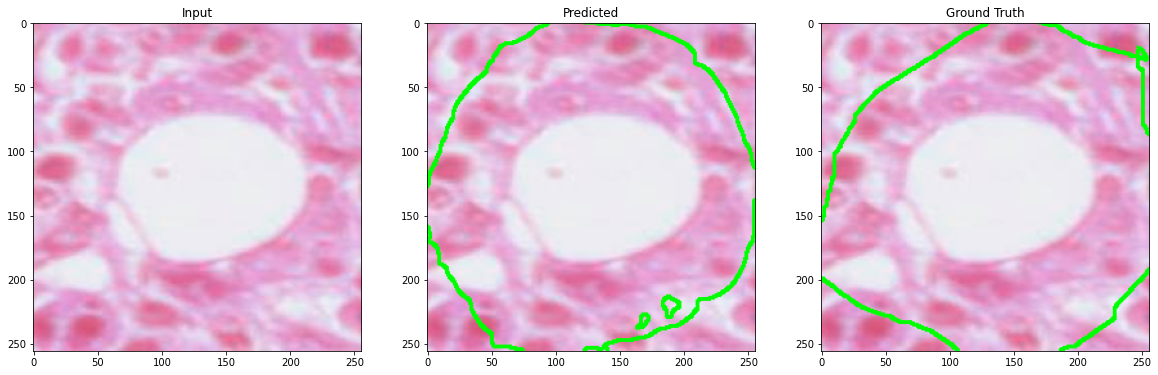

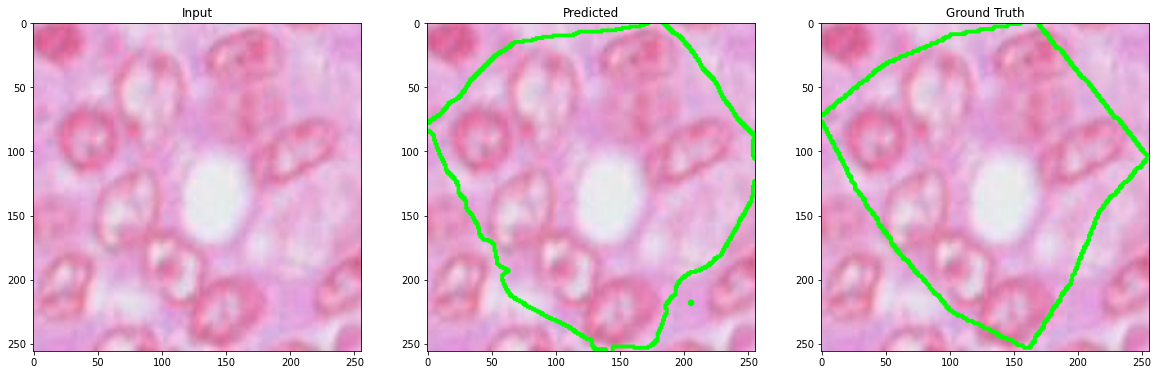

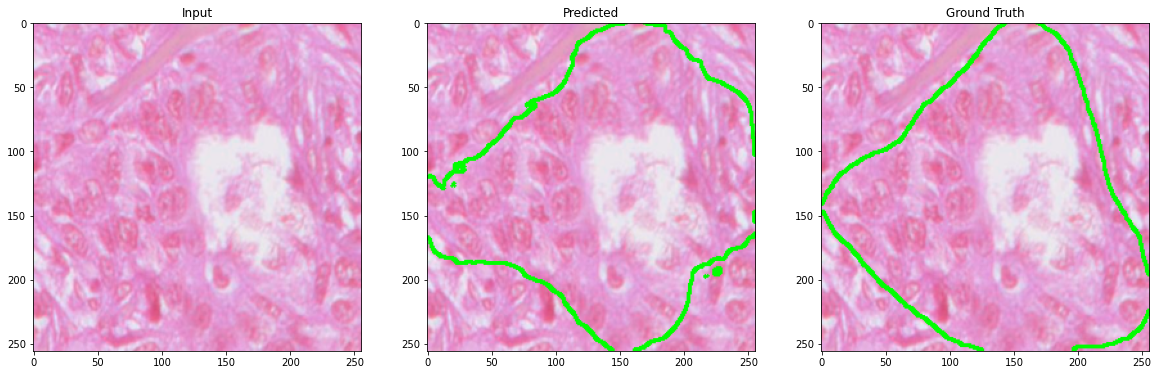

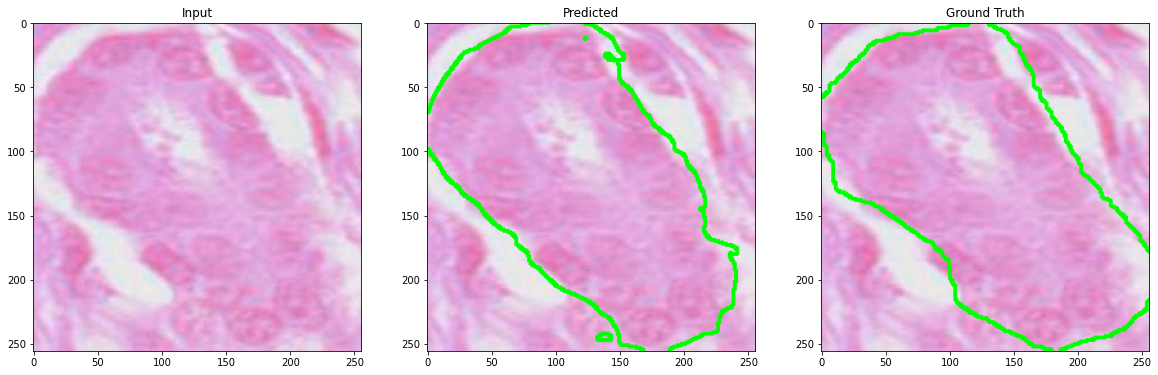

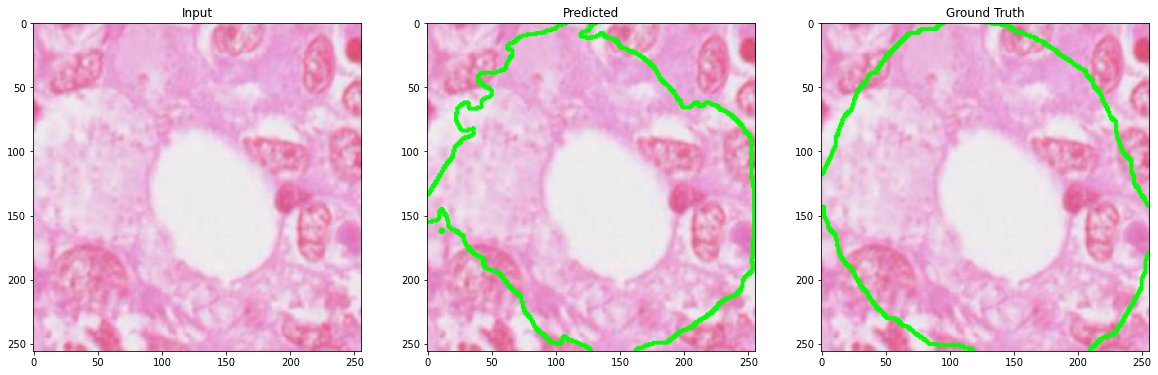

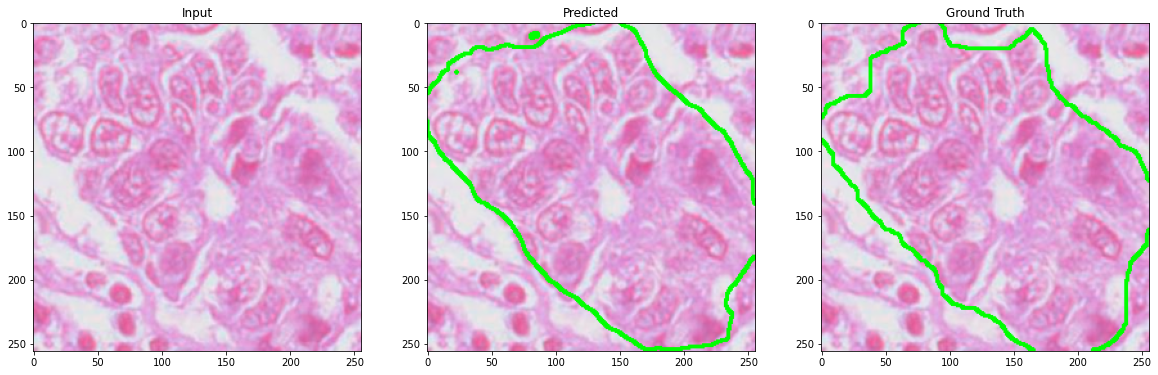

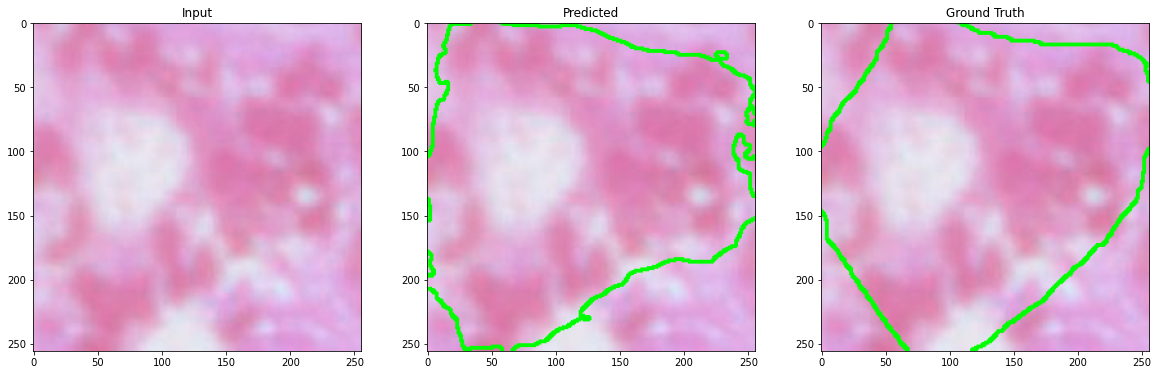

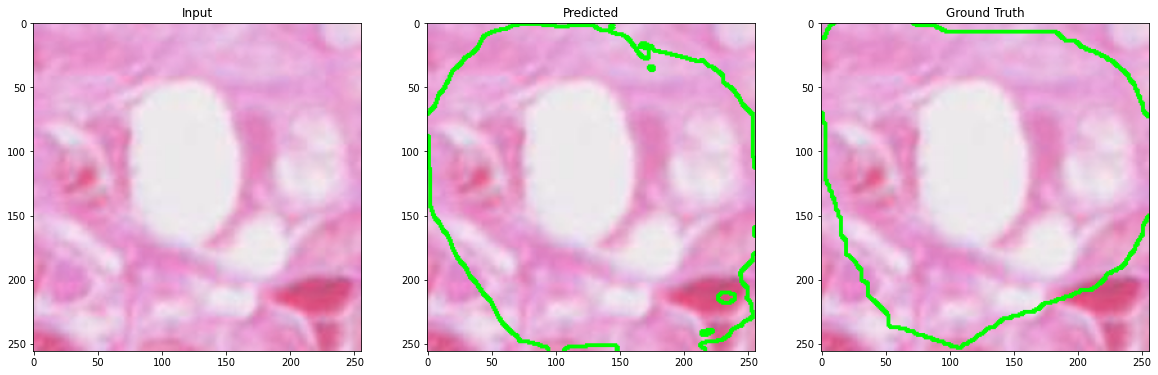

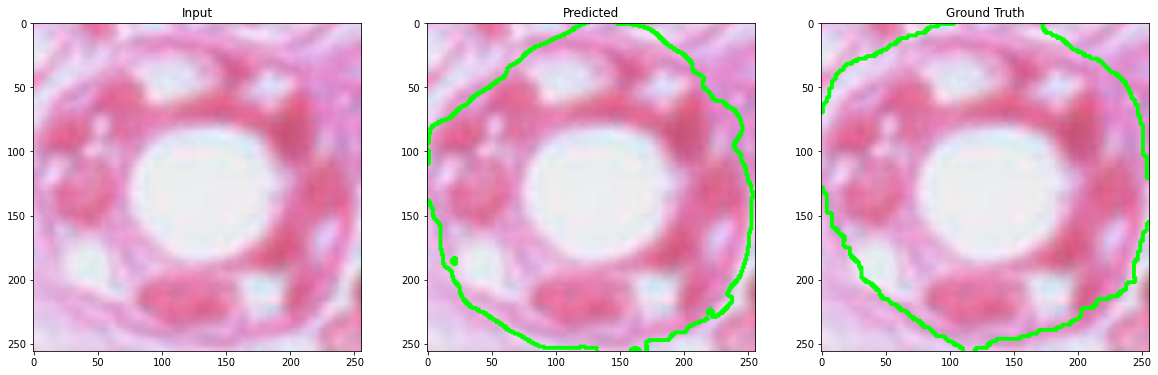

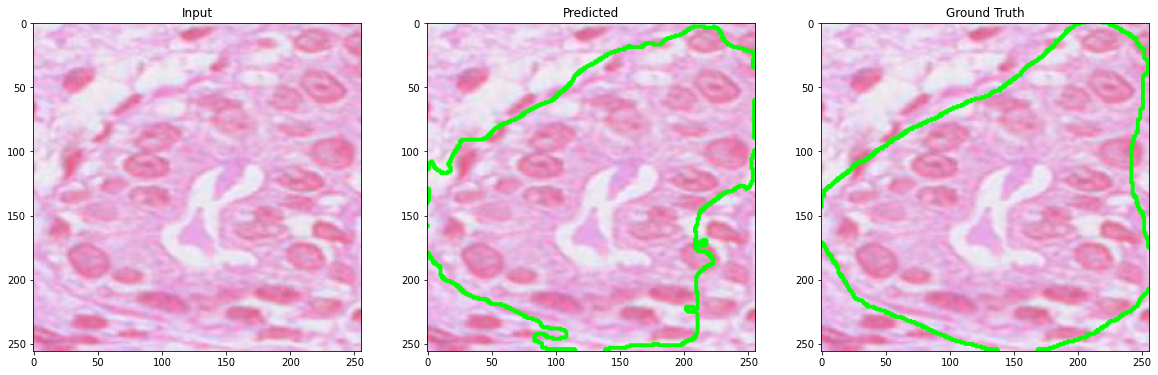

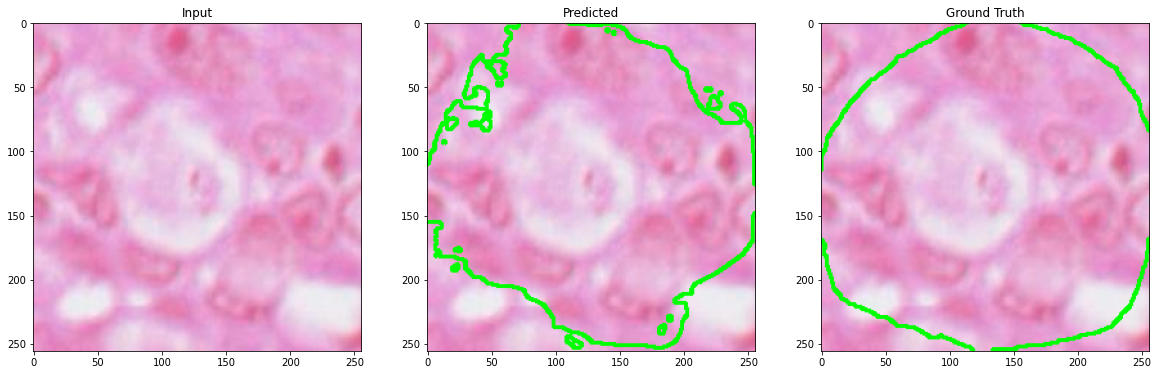

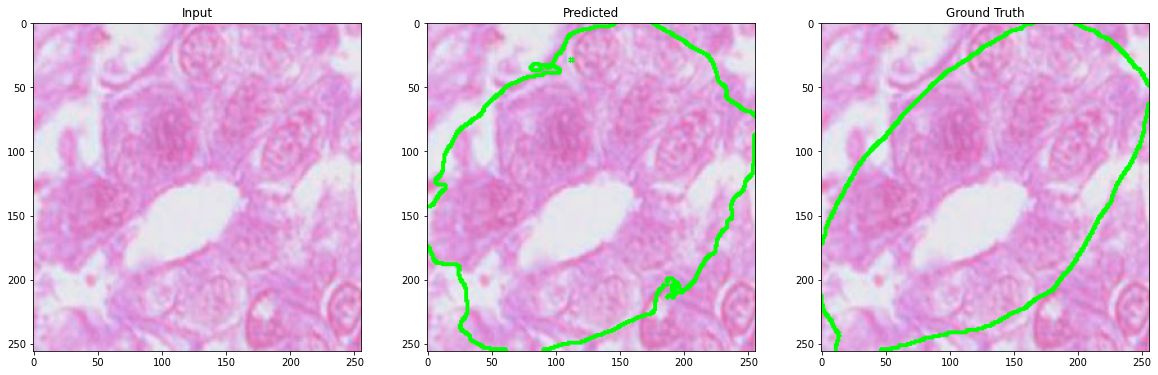

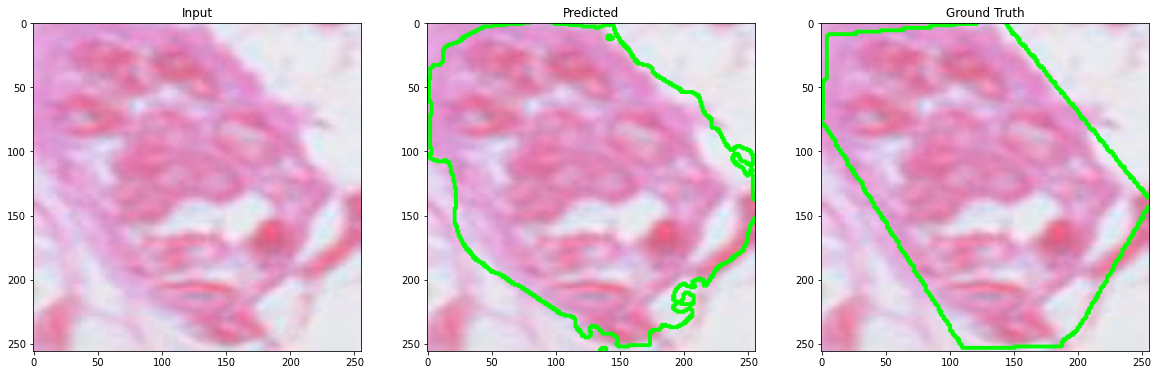

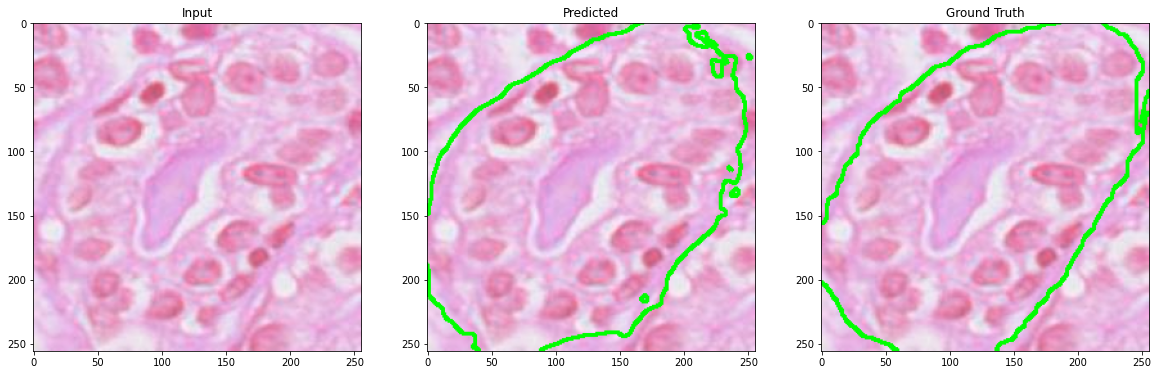

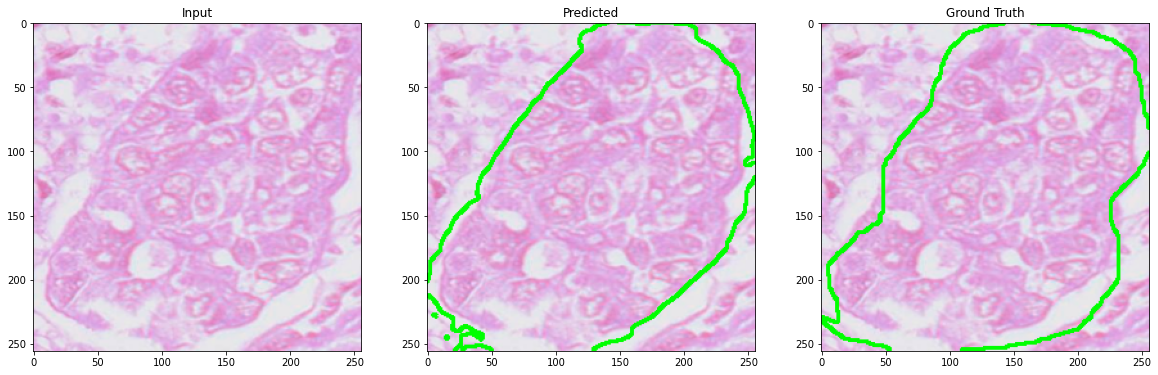

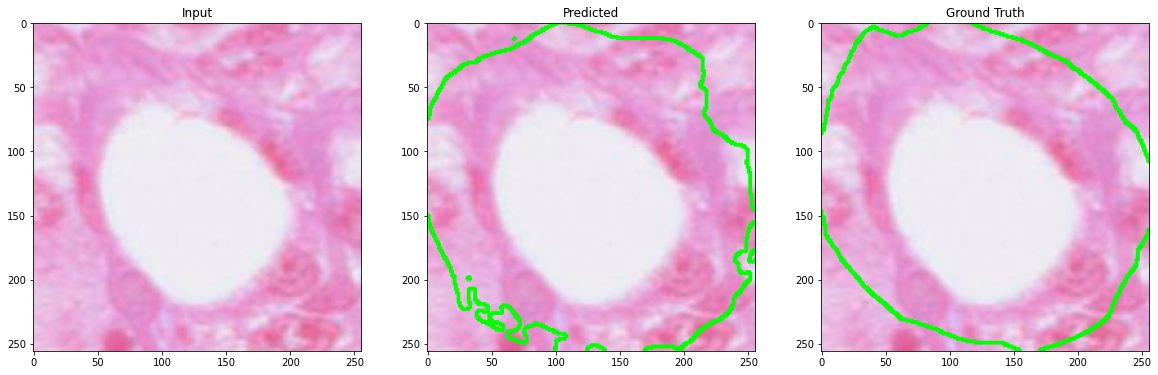

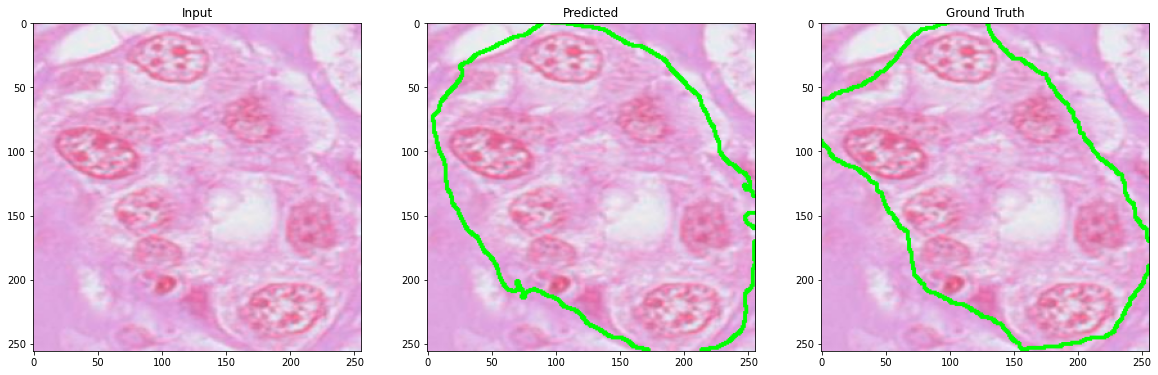

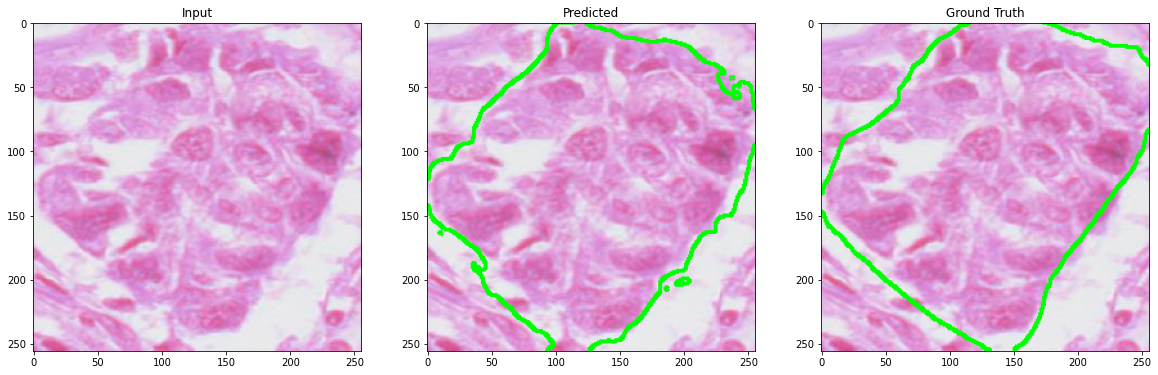

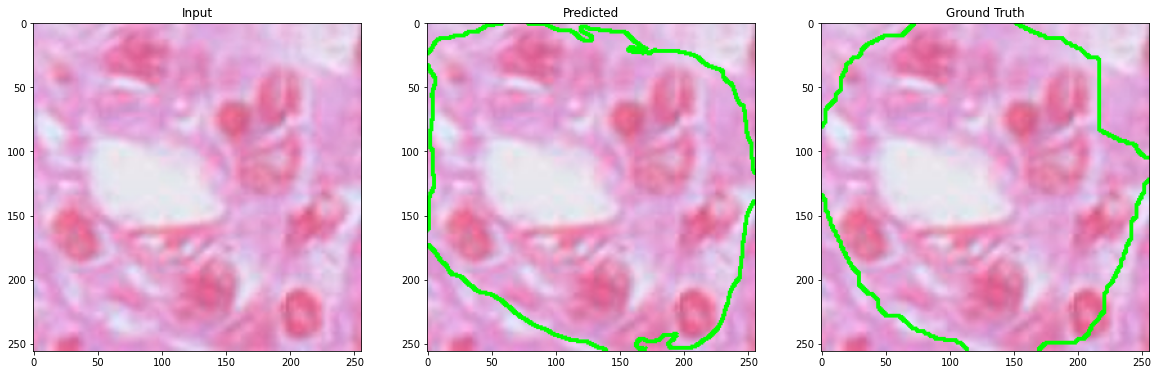

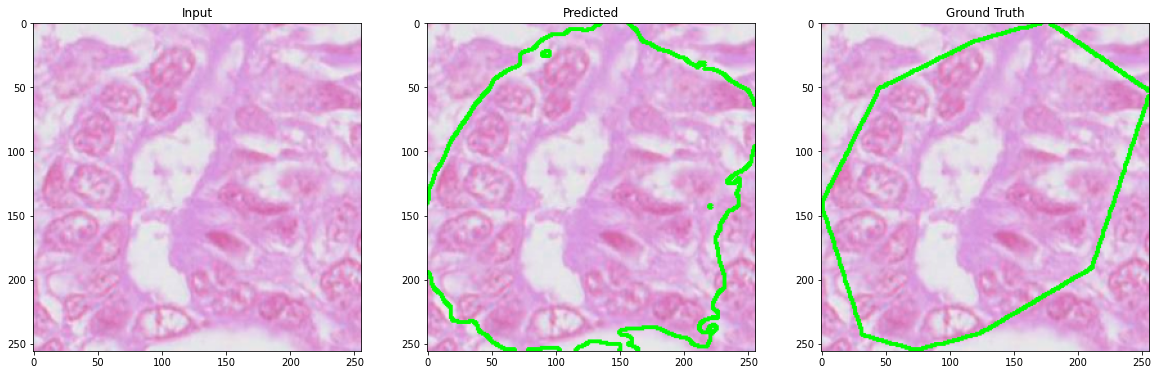

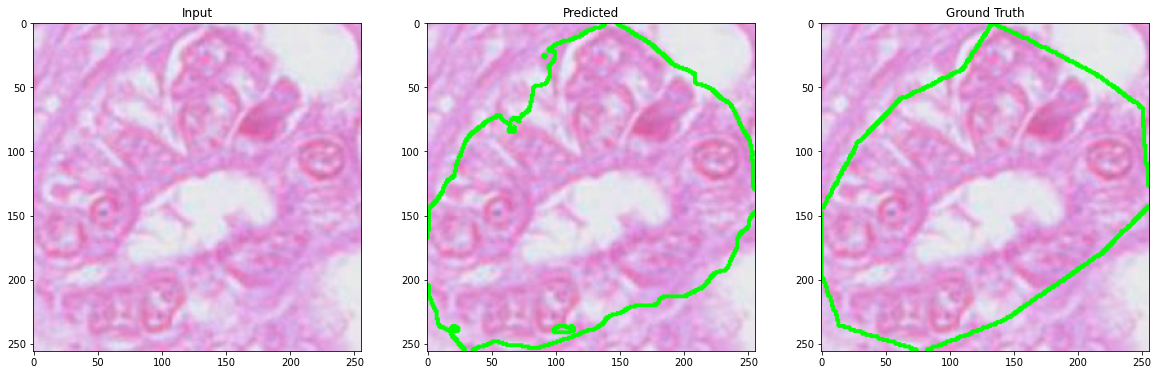

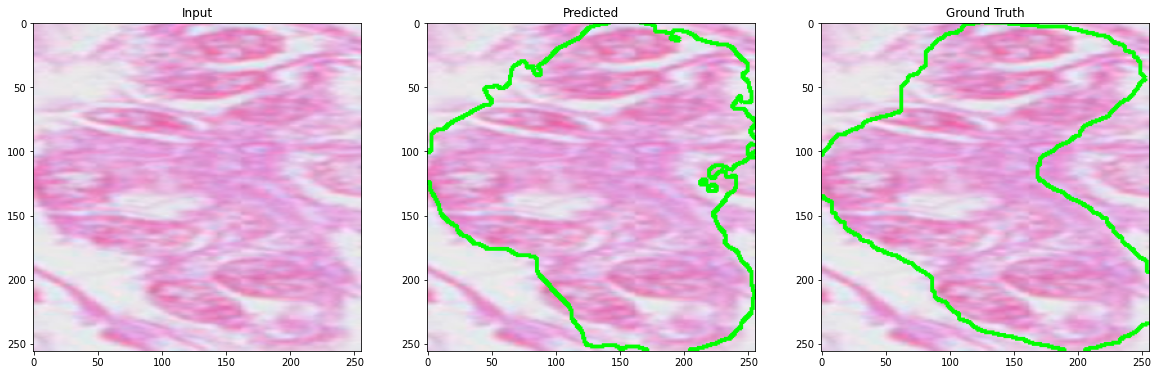

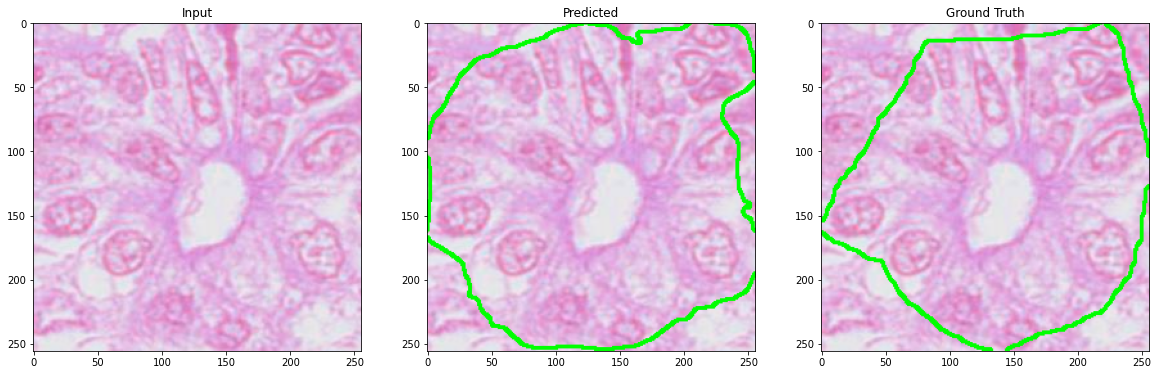

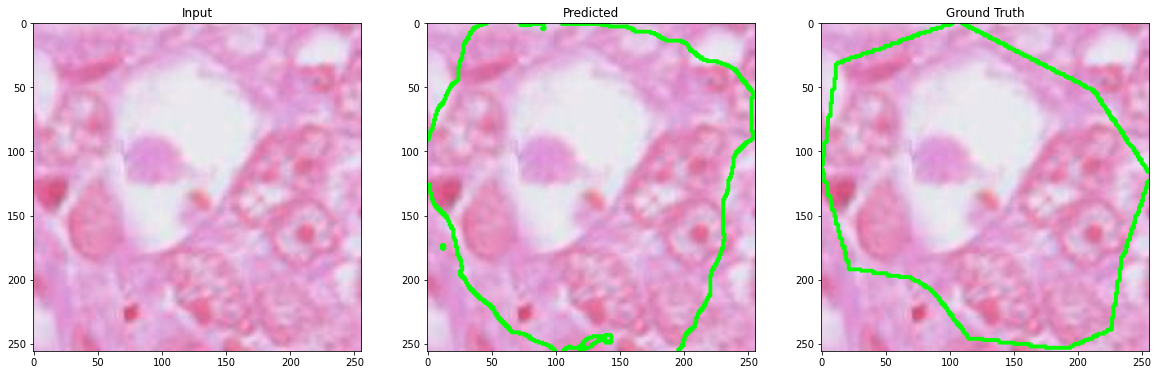

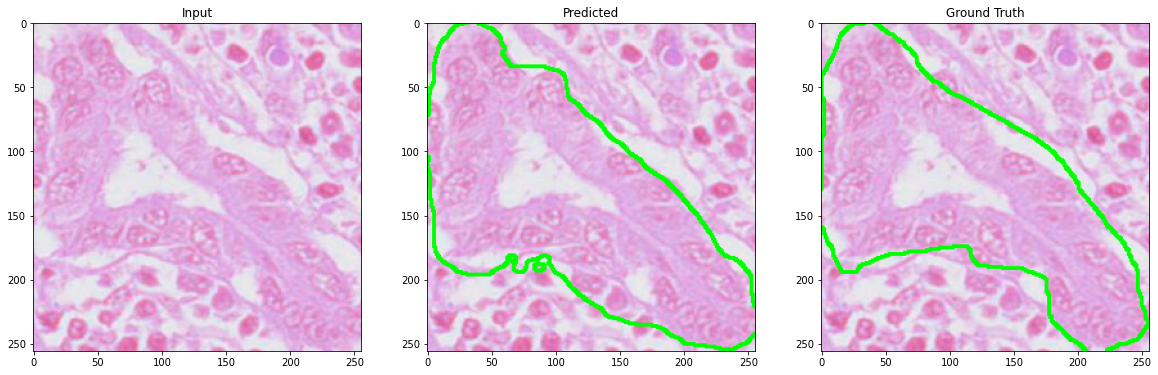

In [19]:
X_Test = x_test.copy()
Y_Test = y_test.copy()
for i in range(25):
    i1 = X_Test[i].copy()
    i2 = X_Test[i].copy()
    fig = plt.figure(figsize=(20,20))
    a = fig.add_subplot(1,3,1)
    a.title.set_text('Input')
    a.imshow(X_Test[i])
    a = fig.add_subplot(1,3,2)
    pred_mask = model1.predict(i1.reshape(1,256,256,3)).reshape(256,256)
    _,pred_mask = cv2.threshold(pred_mask,0.4,1,cv2.THRESH_BINARY)
    pred_mask *= 255
    pred_mask = pred_mask.astype(np.uint8)
    a.title.set_text('Predicted')
    a.imshow(contour_img(X_Test[i].copy(), pred_mask))
    a = fig.add_subplot(1,3,3)
    a.title.set_text('Ground Truth')
    a.imshow(contour_img(X_Test[i].copy(), Y_Test[i].copy()*255))